In [11]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Preprocessing the data

In [12]:
train_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train"
test_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Test"
valid_dir = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Validation"
train_dir_augmented = r"C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\1_Datasets\Train_augmented"

# Setup data inputs
IMG_SIZE = 128

#import data from directory
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

train_data_augmented = tf.keras.preprocessing.image_dataset_from_directory(train_dir_augmented,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = True,
                                                                seed = 42)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis

valid_data = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                                label_mode = "categorical",
                                                                image_size = (IMG_SIZE, IMG_SIZE),
                                                                shuffle = False) # don't shuffle test data for prediction analysis
train_data

Found 19173 files belonging to 7 classes.
Found 23846 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.
Found 2030 files belonging to 7 classes.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [13]:
class_names = train_data.class_names
class_names

['Atelectasis',
 'Effusion',
 'Infiltration',
 'Mass',
 'No_finding',
 'Nodule',
 'Pneumothorax']

## Preprocessing the dataset

In [14]:
#Creating a function to preprocess the images
def preprocess_img(image, label):
  """
  Converts image datatype from 'uint8' -> 'float32' 
  """
  return tf.cast(image, tf.float32), label 

In [15]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE) 
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to validation data
valid_data = valid_data.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
valid_data = valid_data.prefetch(buffer_size = tf.data.AUTOTUNE)

# Map prepreprocessing function to augmented training data
train_data_augmented = train_data_augmented.map(map_func = preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)
train_data_augmented = train_data_augmented.prefetch(buffer_size = tf.data.AUTOTUNE)

# Creating checkpoint callback

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='fine_tuning_best_model.h5',
    save_weights_only=False,  
    monitor='val_accuracy',  
    save_best_only=True, 
    verbose=1  
)

# Fine tuning model

In [20]:
from tensorflow.keras import layers, Model, regularizers

#import the base model
base_model = tf.keras.applications.efficientnet.EfficientNetB6(include_top=False)
base_model.trainable = True

inputs = tf.keras.Input((128,128,3), name='inputs') 
#data augmentation
x = layers.RandomFlip('horizontal')(inputs)
x = layers.RandomBrightness(0.4)(x)
x = layers.RandomContrast(0.4)(x)
# Using efficientnet model
x = base_model(x)
#average pooling 
x = layers.GlobalAveragePooling2D()(x)
#outputs
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

fine_tuning_model = tf.keras.Model(inputs = inputs, outputs = outputs)

#compile the model
fine_tuning_model.compile(
                            optimizer = tf.keras.optimizers.Adam(), 
                            loss = tf.keras.losses.categorical_crossentropy,
                            metrics = ['accuracy']
    )

In [21]:
fine_tuning_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 128, 128, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_brightness_1 (Rando  (None, 128, 128, 3)       0         
 mBrightness)                                                    
                                                                 
 random_contrast_1 (RandomC  (None, 128, 128, 3)       0         
 ontrast)                                                        
                                                                 
 efficientnetb6 (Functional  (None, None, None, 2304   40960143  
 )                           )                                   
                                                           

In [22]:
import random 
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
  
history_fine_tuning = fine_tuning_model.fit(
                                    train_data_augmented,
                                    epochs=8,
                                    validation_data=valid_data,
                                    validation_steps=len(valid_data),
                                    callbacks=[checkpoint_callback]
)

Epoch 1/8


2024-01-19 21:32:53.106726: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/efficientnetb6/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


746/746 [==============================] - ETA: 0s - loss: 1.7046 - accuracy: 0.3504
Epoch 1: val_accuracy improved from -inf to 0.28227, saving model to fine_tuning_best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


746/746 [==============================] - 425s 421ms/step - loss: 1.7046 - accuracy: 0.3504 - val_loss: 1.9660 - val_accuracy: 0.2823
Epoch 2/8
746/746 [==============================] - ETA: 0s - loss: 1.5213 - accuracy: 0.4399
Epoch 2: val_accuracy improved from 0.28227 to 0.36847, saving model to fine_tuning_best_model.h5
746/746 [==============================] - 313s 417ms/step - loss: 1.5213 - accuracy: 0.4399 - val_loss: 1.7804 - val_accuracy: 0.3685
Epoch 3/8
746/746 [==============================] - ETA: 0s - loss: 1.4230 - accuracy: 0.4747
Epoch 3: val_accuracy did not improve from 0.36847
746/746 [==============================] - 311s 414ms/step - loss: 1.4230 - accuracy: 0.4747 - val_loss: 1.9059 - val_accuracy: 0.3527
Epoch 4/8
746/746 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.5133
Epoch 4: val_accuracy did not improve from 0.36847
746/746 [==============================] - 310s 414ms/step - loss: 1.3356 - accuracy: 0.5133 - val_loss: 2.015

# Evaluate the model

In [23]:
fine_tuning_model = tf.keras.models.load_model(r'C:\Users\Hp\Documents\Machine_learning_projects\Chest_X_rays\6_saved_models\fine_tuning_best_model_AVG_2.h5')
fine_tuning_model.evaluate(test_data)

64/64 [==============================] - 20s 244ms/step - loss: 1.8350 - accuracy: 0.3591


[1.835011601448059, 0.35911330580711365]

0

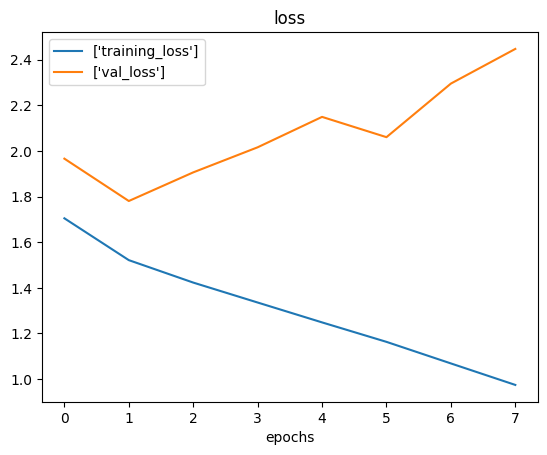

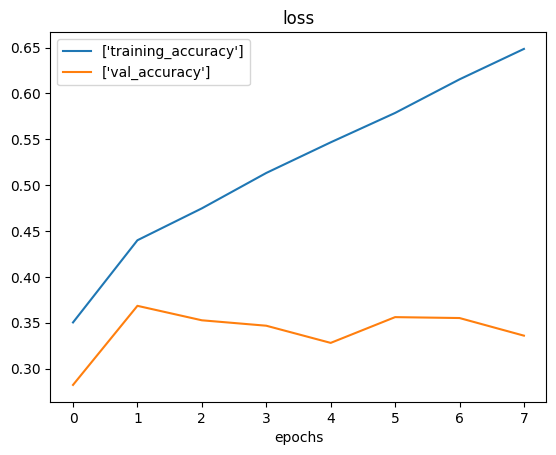

In [26]:
from helper_functions import plot_loss_curve
plot_loss_curve(history_fine_tuning)

## Confusion matrix

In [29]:
from helper_functions import plot_confusion_matrix

# Create valid labels and predictions
valid_labels = []
for images, labels in valid_data.unbatch():
  valid_labels.append(tf.argmax(labels).numpy())
valid_pred_probs = fine_tuning_model.predict(valid_data)
valid_predictions = tf.argmax(valid_pred_probs, axis=1)

64/64 [==============================] - 16s 190ms/step


array([[0.38965517, 0.10344828, 0.0862069 , 0.03103448, 0.16206897,
        0.13448276, 0.09310345],
       [0.09655172, 0.44137931, 0.14827586, 0.03448276, 0.13448276,
        0.08275862, 0.06206897],
       [0.09655172, 0.04827586, 0.22758621, 0.08965517, 0.23448276,
        0.20344828, 0.1       ],
       [0.05862069, 0.05862069, 0.07241379, 0.31034483, 0.16206897,
        0.28275862, 0.05517241],
       [0.07931034, 0.09655172, 0.06896552, 0.07931034, 0.37241379,
        0.2       , 0.10344828],
       [0.03448276, 0.03448276, 0.09655172, 0.12068966, 0.26551724,
        0.37931034, 0.06896552],
       [0.07931034, 0.05862069, 0.08965517, 0.06551724, 0.1137931 ,
        0.13448276, 0.45862069]])

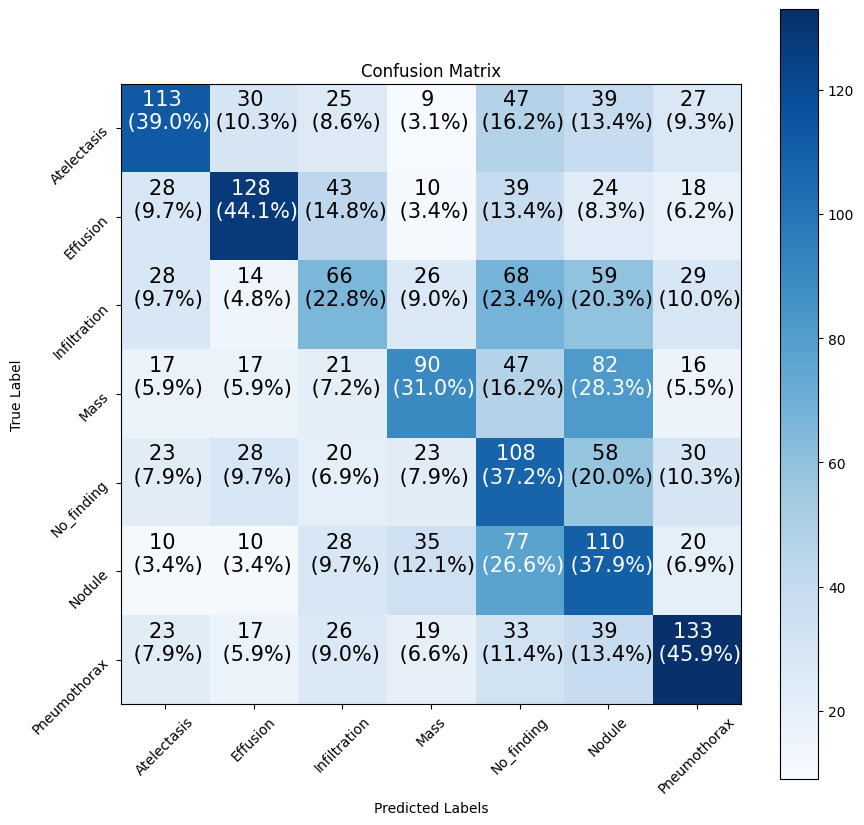

In [30]:
plot_confusion_matrix(valid_labels, valid_predictions, class_names)